In [1]:
import cv2
import pandas as pd
import numpy as np
import os
import pydicom # used for reading dicom files
import math

In [2]:
data_dir="C:/Users/Asus/Desktop/Python stuffs/DL 3d/stage1/stage1/"
patients=os.listdir(data_dir)
labels_df=pd.read_csv("stage1_labels.csv",index_col=0)

In [8]:
labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [4]:
for patient in patients[:1]:
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient   #joining the path of the patient and to check whether the person has cancer or nah....could use os join path
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] # basically reading the the dicom files 
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))          # and sorting them in order
    print(len(slices),label)#this is used to check the slices of scans and the label whether cancer or nah 
    print(len(slices),slices[0].pixel_array.shape) #checking the shape of the pixels
#     print(slices[0]) #CHecking the data...column 512 x Row 512
# len(patients) #lenght of the datset

195 1
195 (512, 512)


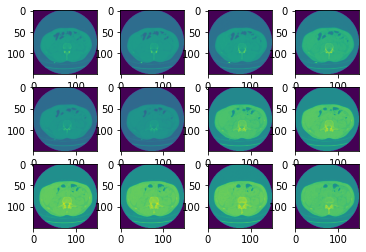

In [5]:
import matplotlib.pyplot as plt
IMG_PX_SIZE=150
for patient in patients[:1]:
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
#     #          the first slice
#     plt.imshow(slices[0].pixel_array)
#     plt.show()
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

In [6]:
IMG_SIZE_PX = 50 #converting the images from 150 to 50
SLICE_COUNT = 20

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)


def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):
    
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    #just to make the data in even slices of 20
    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

much_data = []
for num,patient in enumerate(patients): #patients[:10] for testing if the func works
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels_df,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        much_data.append([img_data,label])
    except KeyError as e:
        print('The data isnt labelled')

np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
